In [1]:
import warnings
warnings.filterwarnings("ignore")

MAX_CASES = 3000


last_action = ""
def counter_message(tot, action):
    global cur, last_action
    
    if last_action != action:
        cur = 1
        last_action = action
    
    print("\r{}/{} {}.".format(cur, tot, action), end=" "*10, flush=True)
    cur += 1

In [2]:
from zipfile import ZipFile
import numpy as np
import pandas as pd

zip_file = ZipFile("data/cases.zip")
case_ids = []
raw_texts = {}
years = {}

names = zip_file.namelist()
names = [name for name in names if not name.startswith('__MACOSX') and name.endswith('.txt')]

if MAX_CASES is None:
    MAX_CASES = len(names)
    
shuffled_names = np.random.permutation(names)[:MAX_CASES]

for file_name in shuffled_names:
    
    year, case_id = file_name[:-4].split("_")
    
    with zip_file.open(file_name) as file:
        raw_text = file.read().decode()
        
    raw_texts[case_id] = raw_text.lower()
    years[case_id] = int(year) 
    
    case_ids.append(case_id)
    
    counter_message(MAX_CASES, "cases opened")
    
outcomes = {}
log_cites = {}
cites = {}
judge_cases = {}
judge_ids = {}
republican = {}

case_metadata = pd.read_csv("data/case_metadata.csv").values
for case_id, outcome, judge_id, year, republican_judge, log_cite in case_metadata:
    if case_id in raw_texts:
        judge_ids[case_id] = judge_id
        outcomes[case_id] = outcome
        if not np.isnan(republican_judge):
            republican[case_id] = int(republican_judge)

2000/2000 cases opened.                                                                                                                                                                                                                                                                                                                               

In [3]:
from gensim.models import Word2Vec
from random import shuffle
import spacy
from gensim.models import KeyedVectors
import random
import plotnine

nlp = spacy.load("en_core_web_sm")

nlp.remove_pipe("parser")
nlp.remove_pipe("ner")
nlp.remove_pipe("tagger")
nlp.add_pipe(nlp.create_pipe('sentencizer'))


sentences = []
rep_sentences = []
dem_sentences = []
for key in republican:
    doc = nlp(raw_texts[key])
    
    for sent in doc.sents:
        sentences.append([word.text for word in sent])
    
    if republican[key] == 1:
        for sent in doc.sents:
            rep_sentences.append([word.text for word in sent])
    elif republican[key] == 0:
        for sent in doc.sents:
            dem_sentences.append([word.text for word in sent])
    
    counter_message(MAX_CASES, "cases tokenized")
    
shuffle(sentences)
shuffle(rep_sentences)
shuffle(dem_sentences)

1645/2000 cases tokenized.          

In [4]:
w2v_window2 = Word2Vec(sentences, size=2, window=2, min_count=25, workers=8)
w2v_window16 = Word2Vec(sentences, size=2, window=16, min_count=25, workers=8)

samples = []
    
for i in range(100):
    samples.append(random.choice(list(w2v_window16.wv.vocab.keys())))

def draw_samples(w2v):
        
    df = pd.DataFrame(columns=['x', 'y', 'label'])
    for key in samples:
        df = df.append({'x': w2v[key][0], 'y': w2v[key][1], 'label': key}, ignore_index=True)
    
    chart = plotnine.ggplot( df, plotnine.aes(x='x', y='y', label='label') ) \
                          + plotnine.geom_text(size=10, alpha=.8)

    chart.draw()

In [5]:
# Word Embedding with a larger window size should also recognize more loose context.

Word Embedding with window size 2



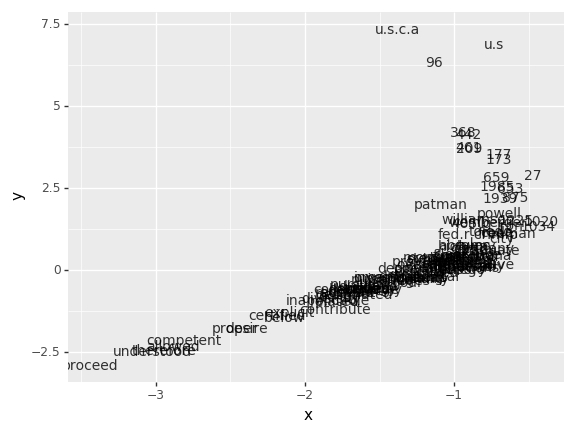

In [6]:
print("Word Embedding with window size 2\n")
draw_samples(w2v_window2)

Word Embedding with window size 16



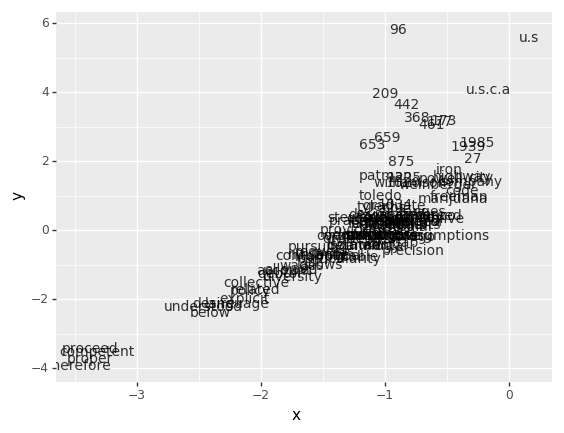

In [7]:
print("Word Embedding with window size 16\n")
draw_samples(w2v_window16)

In [8]:
# claimant vs defendant

dem_cases = []
rep_cases = []

for key in republican:
    if republican[key] == 0:
        dem_cases.append(key)
    if republican[key] == 1:
        rep_cases.append(key)

In [9]:
w2v_dem = Word2Vec(dem_sentences, size=2, window=5, min_count=10, workers=8)
claimant_most_similar_dem = w2v_dem.wv.most_similar(positive=["claimant"], negative=["defendant"], topn=2000, restrict_vocab=None, indexer=None)
defendant_most_similar_dem = w2v_dem.wv.most_similar(positive=["defendant"], negative=["claimant"], topn=2000, restrict_vocab=None, indexer=None)


In [10]:
w2v_rep = Word2Vec(rep_sentences, size=2, window=5, min_count=10, workers=8)
claimant_most_similar_rep = w2v_rep.wv.most_similar(positive=["claimant"], negative=["defendant"], topn=2000, restrict_vocab=None, indexer=None)
defendant_most_similar_rep = w2v_rep.wv.most_similar(positive=["defendant"], negative=["claimant"], topn=2000, restrict_vocab=None, indexer=None)

In [11]:
claimant_most_similar_dem_adj = []
claimant_most_similar_rep_adj = []
defendant_most_similar_dem_adj = []
defendant_most_similar_rep_adj = []

nlp2 = spacy.load("en_core_web_sm")

count = 0
for word in claimant_most_similar_dem:
    if nlp2(word[0])[0].pos_ == "ADJ" and count < 20:
        count += 1
        claimant_most_similar_dem_adj.append(word)
    elif count >= 20:
        break
while count < 20:
    claimant_most_similar_dem_adj.append(("",0))
    count += 1
count = 0
for word in defendant_most_similar_dem:
    if nlp2(word[0])[0].pos_ == "ADJ" and count < 20:
        count += 1
        defendant_most_similar_dem_adj.append(word)
    elif count >= 20:
        break
while count < 20:
    defendant_most_similar_dem_adj.append(("",0))
    count += 1
count = 0
for word in claimant_most_similar_rep:
    if nlp2(word[0])[0].pos_ == "ADJ" and count < 20:
        count += 1
        claimant_most_similar_rep_adj.append(word)
    elif count >= 20:
        break
while count < 20:
    claimant_most_similar_rep_adj.append(("",0))
    count += 1
count = 0
for word in defendant_most_similar_rep:
    if nlp2(word[0])[0].pos_ == "ADJ" and count < 20:
        count += 1
        defendant_most_similar_rep_adj.append(word)
    elif count >= 20:
        break
while count < 20:
    defendant_most_similar_rep_adj.append(("",0))
    count += 1

In [12]:
from tabulate import tabulate


matrix_c = []
matrix_d = []
for i in range(20):
    matrix_c.append([claimant_most_similar_dem_adj[i][0], claimant_most_similar_dem_adj[i][1],
                claimant_most_similar_rep_adj[i][0], claimant_most_similar_rep_adj[i][1]])
    matrix_d.append([defendant_most_similar_dem_adj[i][0], defendant_most_similar_dem_adj[i][1],
                defendant_most_similar_rep_adj[i][0], defendant_most_similar_rep_adj[i][1]])

table_c = tabulate(matrix_c, headers=['dem_adj', 'dem_sim', 'rep_adj', 'rep_sim'])
table_d = tabulate(matrix_d, headers=['dem_adj', 'dem_sim', 'rep_adj', 'rep_sim'])

print("Similarities to \"claimant\":\n")
print(table_c)
print("\n\n")
print("Similarities to \"defendant\":\n")
print(table_d)

Similarities to "claimant":

dem_adj         dem_sim  rep_adj         rep_sim
------------  ---------  ------------  ---------
d.c.cir.1987   1         harris         1
orange         0.999999  f.c.c          1
locomotive     0.999998  french         0.999999
nossa          0.999996  collier        0.999999
elective       0.99999   amalgamated    0.999999
weiner         0.999983  stewart        0.999994
mcdonald       0.999982  orange         0.999991
twin           0.999979  urban          0.999989
i.c.c          0.999972  northwestern   0.999985
brinkman       0.999949  moran          0.999984
bailey         0.999946  kan            0.999978
ryan           0.999929  nom            0.999975
suburban       0.999879  eastern        0.999973
kentucky       0.999847  carlo          0.999966
comm           0.999839  continental    0.999938
nielsen        0.999786  madrid         0.999936
amalgamated    0.999781  stuart         0.999875
texaco         0.999719  roman          0.999851
blue 

In [13]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


w_text = []
y = []
x = []

for key in republican:
    x.append(republican[key])
    y.append(outcomes[key])
    
    doc = [token.text for token in nlp(raw_texts[key])]
    w_text.append(TaggedDocument(doc, [key]))


model = Doc2Vec(w_text, vector_size=100, window=16, min_count=2, workers=8)
w = [model.docvecs[key] for key in republican]



In [14]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from operator import sub

w_a, w_b, y_a, y_b, x_a, x_b = train_test_split(w, y, x, test_size=0.5)

if len(w_a) > len(w_b):
    print(len(w_a))
    w_a = w_a[0:-1] 
    print(len(w_a))

clf_s1_y_a = LogisticRegression().fit(w_a, y_a)
clf_s1_y_b = LogisticRegression().fit(w_b, y_b)
clf_s1_x_a = LogisticRegression().fit(w_a, x_a)
clf_s1_x_b = LogisticRegression().fit(w_b, x_b)

y_b_prob = [tup[0] for tup in clf_s1_y_a.predict_proba(w_b)]
y_a_prob = [tup[0] for tup in clf_s1_y_b.predict_proba(w_a)]
x_b_prob = [tup[0] for tup in clf_s1_x_a.predict_proba(w_b)]
x_a_prob = [tup[0] for tup in clf_s1_x_b.predict_proba(w_a)]


y_a_resid = [[tr-est] for tr,est in zip(y_a, y_a_prob)]
y_b_resid = [[tr-est] for tr,est in zip(y_b, y_b_prob)]
x_a_resid = [[tr-est] for tr,est in zip(x_a, x_a_prob)]
x_b_resid = [[tr-est] for tr,est in zip(x_b, x_b_prob)]


clf_s2_a = LinearRegression().fit(x_a_resid, y_a_resid)
clf_s2_b = LinearRegression().fit(x_b_resid, y_b_resid)

print("Estimator: {}".format(0.5*(clf_s2_a.coef_[0][0]+clf_s2_b.coef_[0][0])))

Estimator: -0.01291383281898601
